In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_rmsle(model):
    pred = model.predict(X_test)
    pred = np.expm1(pred)  # 로그 역변환 (inverse log transformation)
    y_test_exp = np.expm1(y_test)  # 로그 역변환 (inverse log transformation)
    rmsle = np.sqrt(mean_squared_log_error(y_test_exp, pred))
    print(f"{model.__class__.__name__} RMSLE: {np.round(rmsle, 3)}")
    return rmsle

def get_rmsles(models):
    rmsles = []
    for model in models:
        rmsle = get_rmsle(model)
        rmsles.append(rmsle)
    return rmsles

In [3]:
def compare_arrays(arr1, arr2):
    count = 0
    for i in range(len(arr1)):
        if arr1[i] == arr2[i]:
            count += 1
    return count

def convert_values(arr):
    result = []
    for value in arr:
        if value < 85:
            result.append(3)
        elif value < 115:
            result.append(2)
        else:
            result.append(1)
    return result

def get_scores(arr1, arr2):
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(arr1)):
        if arr2[i] == 3 and arr1[i] == 3:
            TP += 1
        elif arr2[i] == 3 and arr1[i] != 3:
            FN += 1
        elif arr2[i] != 3 and arr1[i] != 3:
            TN += 1
        else:
            FP += 1
    print(f"[{TP}   {FP}]\n[{FN}   {TN}]")
    print(f"정밀도 : {round(TP/ (FP+TP)*100,2)}%")
    print(f"재현율 : {round(TP/ (FN+TP)*100,2)}%")
    print(f"정확도 : {round((TP+TN)/len(arr1)*100,2)}%")
    
def convert(x):
    cat = ''
    if x < 90 : cat = 3
    elif x < 110 : cat = 2
    else : cat = 1
    
    return cat

def convert2(x):
    cat = ''
    if x == 3 : cat = 1
    else : cat = 0
    
    return cat    

In [4]:
traindata = pd.read_pickle("dataSet/classtrain.pkl")
testdata = pd.read_pickle("dataSet/classtest.pkl")
traindata = traindata[traindata["선호제휴점포"].isin(traindata["선호제휴점포"].value_counts().index[traindata["선호제휴점포"].value_counts() > 30])]
testdata = testdata[testdata["선호제휴점포"].isin(testdata["선호제휴점포"].value_counts().index[testdata["선호제휴점포"].value_counts() > 30])]

In [5]:
traindata["Label"] = traindata["Label"].apply(lambda x : convert(x))
testdata["Label"] = testdata["Label"].apply(lambda x : convert(x))
traindata["Label"] = traindata["Label"].apply(lambda x : convert2(x))
testdata["Label"] = testdata["Label"].apply(lambda x : convert2(x))

In [6]:
train_ohe = pd.get_dummies(traindata)
test_ohe = pd.get_dummies(testdata)

In [7]:
y_train = train_ohe["Label"]
y_test = test_ohe["Label"]

X_train = train_ohe.drop(["Label"], axis = 1)
X_test = test_ohe.drop(["Label"], axis = 1)

In [8]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)

print(round(accuracy_score(y_test, dt_pred),2))
print(round(accuracy_score(y_test, rf_pred),2))

0.58
0.63


In [20]:
pd.set_option("display.max_columns", None)
traindata

,성별,연령대,거주지역,선호제휴점포,14_1F,14_2F,14_3F,14_4F,15_1F,15_2F,가공변화율,가공순증감률,신선변화율,신선순증감률,일상변화율,일상순증감률,의약변화율,의약순증감률,교육변화율,교육순증감률,디지털변화율,디지털순증감률,가구변화율,가구순증감률,의류변화율,의류순증감률,전문스포츠변화율,전문스포츠순증감률,패션변화율,패션순증감률,명품변화율,명품순증감률,기타변화율,기타순증감률,종합변화율,종합순증감률,R rank,F rank,M rank,Label
0,F,노년층,부산,A29,99.0,111.0,198.0,141.0,107.0,152.0,10,2,1,-1,9,-1,1,-1,3,-1,0,0,7,1,7,1,3,-1,11,-3,3,-1,15,1,0,0,9,4,8,1
1,F,노년층,서울,A2,111.0,70.0,129.0,126.0,153.0,173.0,13,1,7,1,16,0,3,-3,0,0,5,1,4,0,7,3,4,0,0,0,1,-1,15,1,4,0,5,4,10,0
2,F,노년층,서울,B7,270.0,193.0,273.0,273.0,210.0,312.0,7,1,9,-3,14,2,1,-1,2,0,0,0,2,0,5,-3,5,1,8,-2,1,-1,9,-1,7,1,1,8,5,0
4,F,노년층,서울,A20,89.0,99.0,75.0,77.0,130.0,117.0,8,2,16,3,5,1,1,-1,0,0,8,0,8,0,6,0,7,-1,10,2,2,0,17,-5,8,0,1,2,9,0
5,F,노년층,서울,A2,103.0,132.0,193.0,162.0,188.0,157.0,5,-1,7,5,13,3,2,0,2,0,3,1,9,1,0,0,12,0,7,-5,8,0,5,3,4,0,5,5,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19373,F,장년층,서울,B7,133.0,100.0,102.0,126.0,137.0,120.0,8,-2,11,3,6,0,3,-1,0,0,0,0,2,0,4,0,3,-1,8,2,1,-1,7,-3,7,-1,1,4,2,1
19374,F,중년층,경남,C352,331.0,401.0,388.0,425.0,394.0,370.0,12,2,2,0,3,1,1,-1,0,0,0,0,2,0,6,0,7,-1,2,2,3,-1,6,2,7,1,1,10,5,0
19377,F,중년층,서울,C312,312.0,366.0,431.0,418.0,388.0,406.0,2,0,5,2,5,1,1,-1,0,0,0,0,2,0,3,-3,3,-1,6,0,1,-1,2,0,2,0,8,10,5,1
19380,F,노년층,경남,B65,114.0,312.0,271.0,278.0,232.0,255.0,13,1,5,5,12,0,4,0,0,0,2,-2,7,1,15,3,4,-2,19,1,1,-1,11,-1,7,3,1,8,6,0


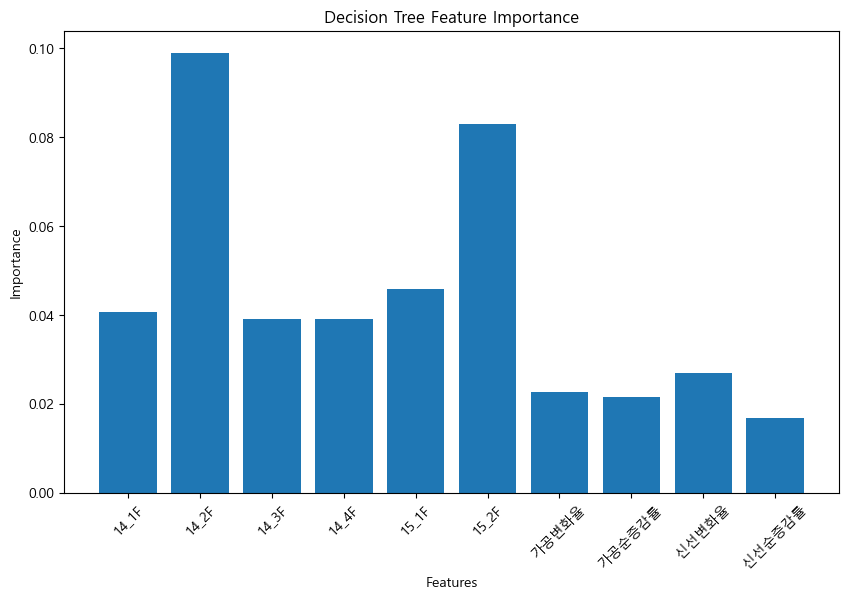

In [16]:
feature_importance_dt = dt.feature_importances_[:20]
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_dt)), feature_importance_dt)
plt.xticks(range(len(feature_importance_dt)), X_train.columns[:10], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Decision Tree Feature Importance')
plt.show()

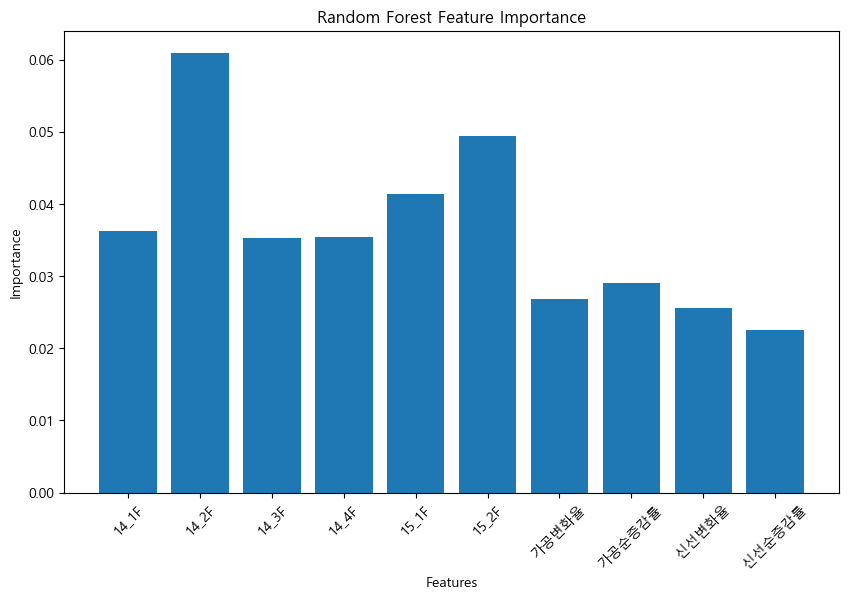

In [18]:
feature_importance_rf = rf.feature_importances_[:10]
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance_rf)), feature_importance_rf)
plt.xticks(range(len(feature_importance_rf)), X_train.columns[:10], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()